https://fleuret.org/dlc/materials/dlc-slides-7-4-VAE.pdf (ref)

In [ ]:
import torch
from torch import nn 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset
from torch.utils.data import default_collate, DataLoader
import matplotlib.pyplot as plt
import math

In [ ]:
def transform(b):
    b['image'] = [TF.to_tensor(o) for o in b['image']]
    return b

def collate_dict(b):
    c = default_collate(b)
    return (c['image'], c['label'])

bs = 1024

data = load_dataset('mnist')
train_data, valid_data = data['train'].with_transform(transform), data['test'].with_transform(transform)
train_dl = DataLoader(train_data, batch_size=bs, shuffle=True, collate_fn=collate_dict) 
valid_dl = DataLoader(valid_data, batch_size=bs*2, shuffle=False, collate_fn=collate_dict)

Reusing dataset mnist (/root/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([1024, 1, 28, 28]) torch.Size([1024])


tensor(5)

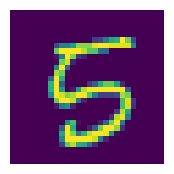

In [ ]:
xb,yb = next(iter(train_dl))
print(xb.shape, yb.shape)
plt.figure(figsize=(2, 2))
plt.imshow(xb[0].permute(1,2,0));
plt.axis('off');yb[0]

In [ ]:
class VAE(nn.Module):
    def __init__(self, nb_channels, latent_dim):
        super().__init__() 
    
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nb_channels, kernel_size=1),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=5),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True), 
            nn.Conv2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True), 
            nn.Conv2d(nb_channels, latent_dim*2, kernel_size=4),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, nb_channels, kernel_size=4),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=3, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=4, stride=2),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, nb_channels, kernel_size=5),
            nn.BatchNorm2d(nb_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nb_channels, 1, kernel_size=5)
        )  
    
    def encode(self, x):
        out = self.encoder(x).view(x.shape[0], 2, -1)
        mu,log_var = out[:,0],out[:,1]
        return mu,log_var
    
    def sample_gaussian(self, mu, log_var):
        std = log_var.mul(0.5).exp()
        return mu + torch.randn(mu.size(), device=mu.device) * std
    
    def decode(self, z):
        mu_hat = self.decoder(z.view(z.shape[0], -1, 1, 1))
        return mu_hat,mu_hat.new_zeros(mu_hat.size())
    
    def log_p_gaussian(self, x, mu_hat, log_var_hat):
        mu_hat,log_var_hat,x = mu_hat.flatten(1),log_var_hat.flatten(1),x.flatten(1)
        var_hat = log_var_hat.exp()
        return -0.5*(((x-mu_hat).pow(2)/var_hat) + log_var_hat + math.log(2*math.pi)).sum(1)     
    
    def dkl(self, dist_a, dist_b):
        mu_a,log_var_a = dist_a[0].flatten(1),dist_a[1].flatten(1)
        mu_b,log_var_b = dist_b[0].flatten(1),dist_b[1].flatten(1)
        var_a = log_var_a.exp()
        var_b = log_var_b.exp()
        return  0.5 * (log_var_b - log_var_a - 1 + (mu_a - mu_b).pow(2) / var_b + var_a / var_b).sum(1)
     
    def forward(self, x):
        mu,log_var = self.encode(x)
        
        z = self.sample_gaussian(mu, log_var)
        
        mu_hat,log_var_hat = self.decode(z)
        
        log_p_given_z = self.log_p_gaussian(x, mu_hat, log_var_hat)
        
        z_prior = (torch.zeros_like(mu), torch.randn_like(log_var))
        dkl_q_vs_z = self.dkl((mu, log_var), z_prior)
        
        loss = -(log_p_given_z-dkl_q_vs_z).mean()
        
        return loss

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda


In [ ]:
m = VAE(nb_channels=8, latent_dim=32).to(device)
o = m(xb.to(device))
o

tensor(1139.5625, device='cuda:0', grad_fn=<NegBackward0>)

In [ ]:
model = VAE(nb_channels=8, latent_dim=32).to(device)
lr = 5e-1
epochs = 10
opt = torch.optim.AdamW(model.parameters(),lr)
for epoch in range(epochs):
    for xb,yb in train_dl:
        xb = xb.to(device)
        loss = model(xb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f'loss:{loss.item():.4f}')

loss:793.0808
loss:758.6329
loss:757.0048
loss:765.5275
loss:765.4188
loss:766.4263
loss:766.4310
loss:765.2722
loss:758.7982
loss:754.8967
